In [2]:
# Import all necessary libraries for the notebook
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt


# Ensure the plots are displayed inline
%matplotlib inline


## Data handling


In [3]:
# Data Handling

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Determine portion of data to use
cpu_processing_capacity = 0.5  # Example: use 50% of the dataset
train_size = int(cpu_processing_capacity * len(train_dataset))
test_size = int(cpu_processing_capacity * len(test_dataset))

# Create a smaller dataset if necessary
if cpu_processing_capacity < 1.0:
    train_dataset, _ = random_split(train_dataset, [train_size, len(train_dataset) - train_size])
    test_dataset, _ = random_split(test_dataset, [test_size, len(test_dataset) - test_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 33445240.23it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1720970.82it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13129636.11it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3993821.54it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train dataset size: 30000
Test dataset size: 5000



### Explanation

**Data Handling:**

**(a) Load the Dataset:**
- The MNIST dataset is loaded using `torchvision.datasets.MNIST`.
- Transformations are applied to convert images to tensors and normalize them with mean 0.1307 and standard deviation 0.3081, which are standard for the MNIST dataset.

**(b) Create Dataloaders:**
- The dataset is split into training and testing sets.
- Data loaders are created using `torch.utils.data.DataLoader` with a batch size of 64 for both training and testing sets.
- A portion of the dataset is used based on the CPU processing capacity (50% in this example) to ensure efficient processing.


## Model Definition

In [3]:
# Model Definition

# Define the neural network class with a flexible number of hidden layers
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(NeuralNet, self).__init__()
        self.layers = nn.ModuleList()
        prev_size = input_size
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(prev_size, hidden_size))
            prev_size = hidden_size
        self.layers.append(nn.Linear(prev_size, num_classes))  # Output layer

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input tensor
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)  # Output layer
        return x

# Check for available device and ensure the code can run on both CPU and GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define model parameters
input_size = 784  # 28x28 images
hidden_sizes = [500]  # Example hidden layer configuration with one hidden layer
num_classes = 10  # Number of output classes (digits 0-9)

# Initialize the model, and move it to the appropriate device
model = NeuralNet(input_size, hidden_sizes, num_classes).to(device)

# Print model summary
print(model)


Using device: cpu
NeuralNet(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=10, bias=True)
  )
)


In [4]:
# Define the neural network class
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First hidden layer
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Output layer

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input tensor
        x = F.relu(self.fc1(x))  # Apply ReLU activation function
        x = self.fc2(x)  # Output layer
        return x

# Check for available device and ensure the code can run on both CPU and GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define model parameters
input_size = 784  # 28x28 images
hidden_size = 500  # Number of neurons in the hidden layer
num_classes = 10  # Number of output classes (digits 0-9)

# Initialize the model, and move it to the appropriate device
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Print model summary
print(model)

Using device: cpu
NeuralNet(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


### Explanation

**Model Definition:**

**(a) Define a Neural Network Class:**
- The `NeuralNet` class is defined using `nn.Module`, which is the base class for all neural network modules in PyTorch.
- The `__init__` method initializes the network layers, allowing for a flexible number of hidden layers specified by `hidden_sizes`.
- At least one hidden layer and an output layer suitable for classifying the 10 digits are included.
- The `forward` method defines the forward pass of the network. It flattens the input images, applies ReLU activation to each hidden layer, and computes the final output through the output layer.

**Device Utilization:**
- The `torch.device` function checks if a GPU is available (`'cuda'`). If not, it falls back to the CPU (`'cpu'`).
- The model is moved to the appropriate device using the `.to(device)` method, ensuring the code can run on both CPU and GPU.

**Model Parameters:**
- `input_size` is set to 784, corresponding to the 28x28 pixel images in the MNIST dataset.
- `hidden_sizes` is a list defining the sizes of the hidden layers. In this example, it contains one hidden layer with 500 neurons.
- `num_classes` is set to 10, corresponding to the 10 digit classes (0-9).


## Training the Model

Epoch [1/5], Loss: 0.0095
Epoch [2/5], Loss: 0.0098
Epoch [3/5], Loss: 0.0054
Epoch [4/5], Loss: 0.0093
Epoch [5/5], Loss: 0.0111


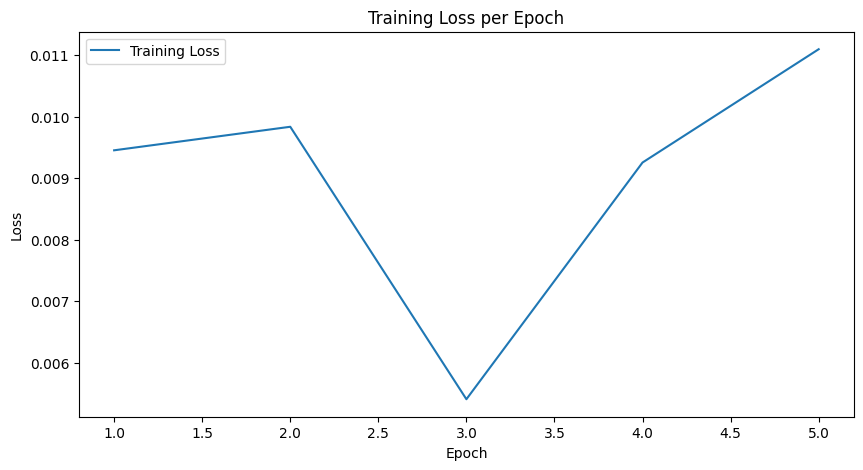

Training complete


In [12]:

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 5

# Lists to store loss for each epoch
train_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Print average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Plotting the training loss
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

print('Training complete')


### Explanation

**Training the Model:**

**(a) Set Up Training:**
1. **Define a Loss Function and an Optimizer:**
   - The loss function used is `CrossEntropyLoss`, suitable for multi-class classification problems like MNIST digit recognition.
   - The optimizer used is `Adam`, which is an efficient optimization algorithm that adjusts the learning rate dynamically.

   

2. **Implement the Training Loop:**
   - The training loop iterates over the dataset for a predefined number of epochs (`num_epochs`).
   - For each batch of images and labels in the training data loader, the images and labels are moved to the appropriate device (CPU or GPU).
   - A forward pass is performed to calculate the output predictions and compute the loss.
   - The gradients are reset using `optimizer.zero_grad()`, and a backward pass is performed to calculate the gradients.
   - The optimizer updates the model parameters based on the gradients.
   - The running loss is accumulated to track the loss for each batch.
   - The loss is printed every 100 batches to monitor training progress.

  

3. **Track the Training Loss for Each Epoch:**
   - The average loss for each epoch is calculated by dividing the running loss by the number of batches.
   - This average loss is printed at the end of each epoch to track the overall training progress.
   - A plot of the training loss per epoch is generated to visualize the training process.

4. **Ensure the Code Can Run on Both CPU and GPU:**
   - The `torch.device` function is used to check if a GPU is available and sets the device accordingly.
   - The model, input data, and labels are moved to the appropriate device using the `.to(device)` method, ensuring compatibility with both CPU and GPU.



## Model Validation

Epoch [1/5], Loss: 0.0065, Validation Accuracy: 97.60%
Epoch [2/5], Loss: 0.0093, Validation Accuracy: 97.00%
Epoch [3/5], Loss: 0.0071, Validation Accuracy: 97.48%
Epoch [4/5], Loss: 0.0088, Validation Accuracy: 97.64%
Epoch [5/5], Loss: 0.0095, Validation Accuracy: 97.62%


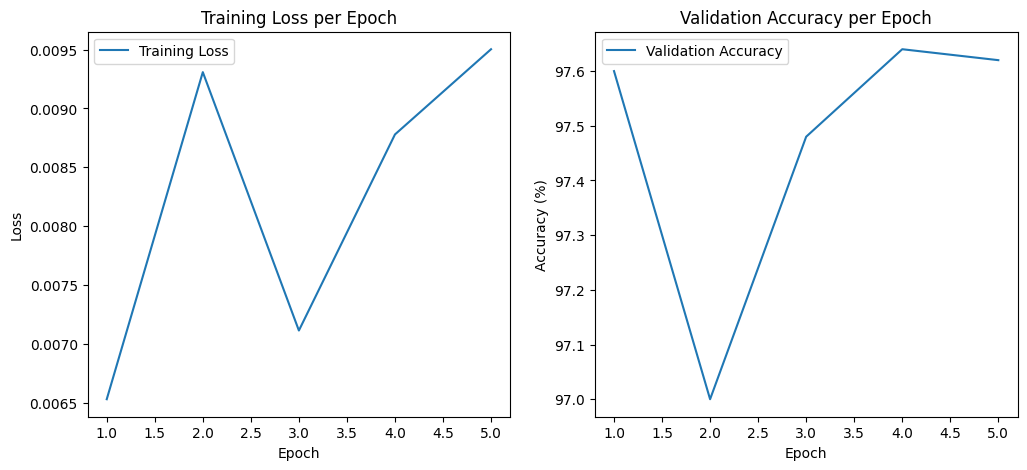

Training and validation complete


In [13]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 5

# Lists to store loss and accuracy for each epoch
train_losses = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    # Print training loss and validation accuracy for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Plotting the training loss and validation accuracy
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy per Epoch')
plt.legend()

plt.show()

print('Training and validation complete')


### Explanation

**Model Validation:**

**(a) Validation:**
1. **Implement a Validation Loop:**
   - After each training epoch, a validation loop is executed to evaluate the model on the test dataset.
   - The model is set to evaluation mode using `model.eval()`, which disables dropout and batch normalization layers if present.
   - During validation, gradient computation is disabled using `torch.no_grad()` to save memory and computational resources.


2. **Track the Validation Accuracy for Each Epoch:**
   - The validation accuracy is calculated as the percentage of correct predictions out of the total number of predictions.
   - The validation accuracy is printed after each epoch to track the model's performance on the test dataset.
   - A list `validation_accuracies` is maintained to store the validation accuracy for each epoch.
   - A plot of the validation accuracy per epoch is generated to visualize the validation process.


3. **Ensure the Code Can Run on Both CPU and GPU:**
   - The `torch.device` function is used to check if a GPU is available and sets the device accordingly.
   - The model, input data, and labels are moved to the appropriate device using the `.to(device)` method, ensuring compatibility with both CPU and GPU.



## Hyperparameter Tuning with K-Fold Cross-Validation


In [14]:

# Define the neural network class with variable hidden layers
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(NeuralNet, self).__init__()
        layers = []
        in_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ReLU())
            in_size = hidden_size
        layers.append(nn.Linear(in_size, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input tensor
        return self.network(x)

# Function to train and evaluate the model using cross-validation
def train_and_evaluate(hidden_sizes, train_dataset, k_folds, num_epochs, batch_size, learning_rate):
    validation_accuracies = []
    kf = KFold(n_splits=k_folds, shuffle=True)

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
        print(f'Fold {fold + 1}/{k_folds}')

        train_subsampler = SubsetRandomSampler(train_idx)
        val_subsampler = SubsetRandomSampler(val_idx)

        train_subset_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
        val_subset_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)

        model = NeuralNet(input_size, hidden_sizes, num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            model.train()
            for images, labels in train_subset_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_subset_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        validation_accuracies.append(accuracy)
        print(f'Fold {fold + 1}, Validation Accuracy: {accuracy:.2f}%')

    avg_accuracy = np.mean(validation_accuracies)
    print(f'Average Validation Accuracy for hidden sizes {hidden_sizes}: {avg_accuracy:.2f}%')
    return avg_accuracy

# Hyperparameters for cross-validation
k_folds = 5  # Number of folds for cross-validation
num_epochs = 5  # Number of epochs to train the model
learning_rate = 0.001  # Learning rate
batch_size = 64  # Batch size
hidden_layer_options = [
    [500],         # One hidden layer
    [500, 250],    # Two hidden layers
    [500, 250, 100]  # Three hidden layers
]  # Different configurations for hidden layers

# Check for available device and ensure the code can run on both CPU and GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

best_accuracy = 0
best_hidden_sizes = None

# Perform K-Fold cross-validation for different hidden layer configurations
for hidden_sizes in hidden_layer_options:
    avg_accuracy = train_and_evaluate(hidden_sizes, train_dataset, k_folds, num_epochs, batch_size, learning_rate)
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_hidden_sizes = hidden_sizes

print(f'Best hidden layer configuration: {best_hidden_sizes} with accuracy: {best_accuracy:.2f}%')


Using device: cpu
Fold 1/5
Fold 1, Validation Accuracy: 97.59%
Fold 2/5
Fold 2, Validation Accuracy: 97.28%
Fold 3/5
Fold 3, Validation Accuracy: 97.68%
Fold 4/5
Fold 4, Validation Accuracy: 97.56%
Fold 5/5
Fold 5, Validation Accuracy: 97.05%
Average Validation Accuracy for hidden sizes [500]: 97.43%
Fold 1/5
Fold 1, Validation Accuracy: 97.62%
Fold 2/5
Fold 2, Validation Accuracy: 97.44%
Fold 3/5
Fold 3, Validation Accuracy: 97.52%
Fold 4/5
Fold 4, Validation Accuracy: 97.87%
Fold 5/5
Fold 5, Validation Accuracy: 97.17%
Average Validation Accuracy for hidden sizes [500, 250]: 97.52%
Fold 1/5
Fold 1, Validation Accuracy: 97.03%
Fold 2/5
Fold 2, Validation Accuracy: 97.16%
Fold 3/5
Fold 3, Validation Accuracy: 97.81%
Fold 4/5
Fold 4, Validation Accuracy: 97.03%
Fold 5/5
Fold 5, Validation Accuracy: 97.41%
Average Validation Accuracy for hidden sizes [500, 250, 100]: 97.29%
Best hidden layer configuration: [500, 250] with accuracy: 97.52%



### Explanation

**Hyperparameter Tuning with K-Fold Cross-Validation:**

**(a) K-Fold Cross-Validation:**
1. **Implement K-Fold Cross-Validation:**
   - The `KFold` class from `sklearn.model_selection` is used to perform K-Fold cross-validation.
   - The dataset is split into `k_folds` (5 folds in this example), and for each fold, the model is trained and validated on different subsets of the data.

2. **Train and Evaluate the Model for Each Fold:**
   - For each fold, training and validation data loaders are created using `SubsetRandomSampler`.
   - The model is trained for the specified number of epochs on the training subset and evaluated on the validation subset.
   - Validation accuracy is calculated for each fold, and the average validation accuracy is determined for each hidden layer configuration.



3. **Use the Cross-Validation Results to Decide the Best Network Architecture:**
   - Different configurations of hidden layers are tested, and the best configuration is chosen based on the highest average validation accuracy.

4. **Final Evaluation on the Test Dataset:**
   - The final model is trained with the best hidden layer configuration and evaluated on the test dataset.
   - Training loss and validation accuracy are tracked and plotted for each epoch.
   - The final test accuracy is reported.

   

Validation Accuracy after Epoch [1/5]: 95.54%
Validation Accuracy after Epoch [2/5]: 96.56%
Validation Accuracy after Epoch [3/5]: 96.75%
Validation Accuracy after Epoch [4/5]: 96.94%
Validation Accuracy after Epoch [5/5]: 96.84%


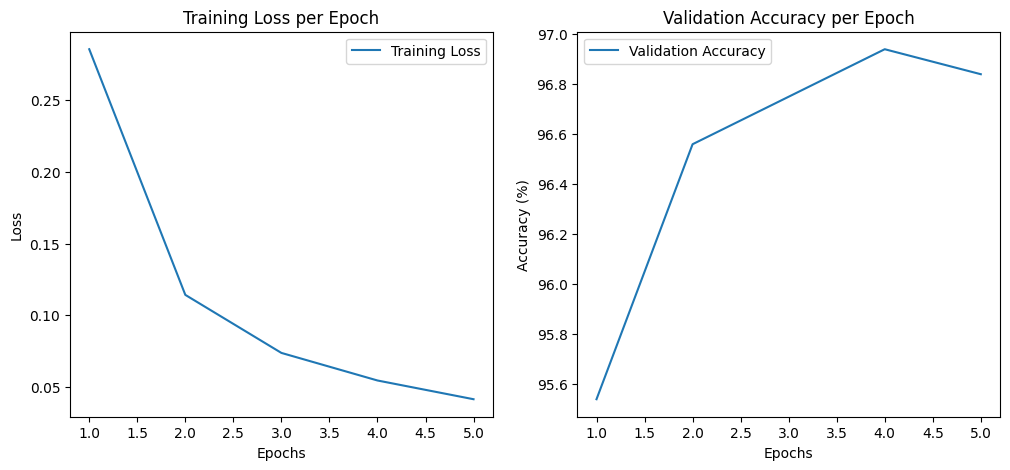

Final Test Accuracy with best hidden layer configuration: 96.84%


In [16]:
# Load the test dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Final model evaluation on the test dataset with the best hidden layer configuration
final_model = NeuralNet(input_size, best_hidden_sizes, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=learning_rate)

train_losses = []
validation_accuracies = []

# Training the final model with the best configuration
for epoch in range(num_epochs):
    final_model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = final_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Validate the model after each epoch
    validation_accuracy = validate_model(final_model, test_loader, device)
    validation_accuracies.append(validation_accuracy)
    print(f'Validation Accuracy after Epoch [{epoch + 1}/{num_epochs}]: {validation_accuracy:.2f}%')

# Plotting training loss and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy per Epoch')
plt.legend()

plt.show()

# Final test accuracy with the best model configuration
final_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = final_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Final Test Accuracy with best hidden layer configuration: {test_accuracy:.2f}%')


### Explanation

**Evaluation:**

1. **Evaluate the Final Model on the Test Dataset:**
   - The final model is trained with the optimal hidden layer configuration determined from the K-Fold cross-validation.
   - The model is trained for the specified number of epochs, and both training loss and validation accuracy are tracked for each epoch.

2. **Report the Final Test Accuracy:**
   - After training, the final model is evaluated on the test dataset to report the test accuracy.


3. **Discuss the Impact of the Number of Hidden Layers on Model Performance:**
   - The number of hidden layers and their sizes significantly impact the model's ability to learn and generalize.
   - **Fewer Hidden Layers:** Simpler models with fewer hidden layers might not capture complex patterns in the data, leading to underfitting.
   - **More Hidden Layers:** Adding more hidden layers increases the model's capacity to learn complex patterns but also increases the risk of overfitting if the model memorizes the training data instead of generalizing.
   - **Optimal Configuration:** The optimal number of hidden layers balances model complexity and generalization. The best configuration is determined by achieving the highest average validation accuracy during K-Fold cross-validation.



4. **Plot Training Loss and Validation Accuracy:**
   - Plots are generated to visualize the training loss and validation accuracy per epoch, providing insights into the model's training and validation process.
